# Importing Data

In [352]:
import sys
import os
import math
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import geodatasets
import geopandas as gpd
import re
import folium
from folium import plugins
import earthpy as et
import webbrowser
from matplotlib.colors import LogNorm, Normalize
from matplotlib.cm import get_cmap
from branca.colormap import LinearColormap
import statsmodels.api as sm
from scipy.stats import norm
import elevation
import shapely.geometry
from shapely.geometry import Point, box, Polygon, MultiPolygon
import seaborn as sns
from shapely.wkt import loads
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go
import plotly.io as pio
import plotly.express as px
import rasterio
from rasterio.plot import show
from rasterio.warp import reproject, Resampling, calculate_default_transform
from rasterio.transform import from_bounds, from_origin
from rasterio.mask import mask
import earthpy.spatial as es
from scipy.interpolate import RegularGridInterpolator
from matplotlib.backends.backend_pdf import PdfPages
import streamlit as st
import matplotlib.colors as mcolors
import PyCO2SYS as cs

from scipy.optimize import curve_fit



In [353]:
df = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Nepal Master Sheet.xlsx', sheet_name='Final_compiled')

df_abra = pd.read_excel('/Users/enrico/Desktop/Part III Project/Code/Nepal-1/Datasets/Abra.xlsx', sheet_name='Sheet1')

df_copy = df.copy()

In [354]:
df_copy = df_copy[df_copy['Sample type'] == 'Spring water']    

In [355]:
# Convert concentrations from ppm to mM
df_copy['Ca_mM'] = df_copy['Ca_ppm'] / 40.08
df_copy['Sr_mM'] = df_copy['Sr_ppm'] / 87.62
df_copy['Mg_mM'] = df_copy['Mg_ppm'] / 24.31
df_copy['Si_mM'] = df_copy['Si_ppm'] / 28.09
df_copy['Na_mM'] = df_copy['Na_ppm'] / 22.99
df_copy['Li_mM'] = df_copy['Li_ppm'] / 6.94
df_copy['K_mM'] = df_copy['K_ppm'] / 39.10
df_copy['Al_mM'] = df_copy['Al_ppm'] / 26.98
df_copy['Li_uM'] = df_copy['Li_mM'] * 1000

# Convert Cl from molar to mM
df_copy['Cl_mM'] = df_copy['Cl_molar'] / 1000

# Calculate ion ratios
df_copy['Na/Ca'] = df_copy['Na_mM'] / df_copy['Ca_mM']
df_copy['Ca/Na'] = df_copy['Ca_mM'] / df_copy['Na_mM']
df_copy['Mg/Ca'] = df_copy['Mg_mM'] / df_copy['Ca_mM']
df_copy['Mg/Na'] = df_copy['Mg_mM'] / df_copy['Na_mM']
df_copy['Ca/Sr'] = df_copy['Ca_mM'] / df_copy['Sr_mM']
df_copy['1000xSr/Ca'] = df_copy['Sr_mM'] / df_copy['Ca_mM'] * 1000
df_copy['Si/Ca'] = df_copy['Si_mM'] / df_copy['Ca_mM']



df_copy['Si_mol/l'] = df_copy['Si_mM'] / 1000
df_copy['Si_uM'] = df_copy['Si_mM'] * 1000  
df_copy['Na_uM'] = df_copy['Na_mM'] * 1000
df_copy['Ca_uM'] = df_copy['Ca_mM'] * 1000
df_copy['Cl_uM'] = df_copy['Cl_mM'] * 1000

In [356]:
#print the sample ID for the max Ca value
print(df_copy[df_copy['Ca_mM'] == df_copy['Ca_mM'].max()]['Sample ID'])

162    NEP23-01
Name: Sample ID, dtype: object


In [357]:
# print Ca_uM and SAMPLE ID for the max Ca value   
print(df_copy[df_copy['Ca_uM'] == df_copy['Ca_uM'].max()][['Sample ID', 'Ca_uM']])

# remove the sample with the max Ca value
df_copy = df_copy[df_copy['Sample ID'] != 'NEP22-57']

    Sample ID        Ca_uM
162  NEP23-01  1219.118014


In [358]:
def assign_traverse(gns):
    if not isinstance(gns, str):  # Handle non-string values
        return None

    # Normalize the GNS by stripping suffixes and quotes
    gns = gns.split('22')[0].split('23')[0].strip("'").strip('"')
    
    # S1 group
    if gns.startswith("S1"):
        if gns in ["S1m", "S1i"]:  # Special cases for Traverse 1*
            return "Traverse 1*"
        return "Traverse 1"
    # S2 group
    elif gns.startswith("S2"):
        return "Traverse 2"
    # S3 group
    elif gns.startswith("S3"):
        if gns in ["S3k", "S3m", "S3u", "S3s", "S3ag", "S3ad"]:  # Special cases for Traverse 4
            return "Traverse 4"
        elif gns in ["S3y", "S3ae"]:  # Special cases for Traverse 3*
            return "Traverse 3*"
        return "Traverse 3"  # Default case for S3
    # S4 group
    elif gns.startswith("S4"):
        if gns in ["S4m", "S4l"]:  # Special cases for Traverse 5*
            return "Traverse 5*"
        return "Traverse 5"
    # Default case for unknown values
    return None



# Apply the function to create the new column
df_copy["Traverse"] = df_copy["GNS"].apply(assign_traverse)


In [359]:
df_copy = df_copy[df_copy['Traverse'] == 'Traverse 3']

# Calculate distance for Abra samples for their longitude. Do longitude 85.5984 minus the longitude of the sample. Then convert to meters to give a new 'x' column
df_copy['x'] = (85.5984 - df_copy['Longitude']) * 111000

# calculate elevation difference between df_abra['Elevation'] and the elevation of the ridge
df_copy['y'] = 2600 - df_copy['Elevation']

df_copy['x+y'] = df_copy['x'] + df_copy['y']

# calculate sqrt(x^2 + y^2) for each sample
df_copy['distance_from_ridge'] = np.sqrt(df_copy['x']**2 + df_copy['y']**2)

df_copy['2(x+y)'] = 2 * df_copy['x+y']


# print x+y, distance from ridge and 2(x+y)
#print(df_copy[['x+y', 'distance_from_ridge', '2(x+y)', 'Sample ID']])

In [360]:
# Initialize a dictionary to store h distributions
h_distributions = {}

# Loop through each sample to calculate the h range
for index, row in df_copy.iterrows():
    sample_id = row['Sample ID']  # Assuming 'Sample ID' uniquely identifies each sample
    # Generate 1000 evenly spaced h values for the sample
    h_values = np.linspace(row['distance_from_ridge'], row['2(x+y)'], 1000)
    # Store in the dictionary
    h_distributions[sample_id] = h_values
    
    

# Modelling

In [361]:
variable = 'Na_uM'

# define Co
C_zero = df_copy[variable].min()
C_max = df_copy[variable].max()

C_eq = C_max

# Cmax we have is greater than C_eq they have. Threfore we wil set our Cmax as C_eq. Is this valid???


In [362]:
# ##### USING BRANTLEY AND WHITE EQUATION FOR T


# # Constants
# C_zero = df_copy[variable].min()  # Ensure `variable` exists and is numeric
# C_max = df_copy[variable].max()
# C_eq = C_max*2

# tau = np.exp(2)
# phi = 0.15
# rho_min = 2.67  # g/cm^3
# rho_sf = 1000 * rho_min / phi  # g/L
# A_surf = 0.1
# x_r = 0.36
# f_w = 1  # approximately

# # Calculate B
# B = tau * rho_sf * A_surf * x_r * f_w * phi * (3.1 * 10**-7)

# # Empty list for time results
# times = []

# for index, row in df_copy.iterrows():
#     try:
#         # Calculate numerator and denominator
#         numerator = (C_eq / B) * (row[variable] - C_zero)
#         denominator = (C_eq - row[variable])
        
#         # Ensure denominator is not zero or negative
#         if denominator <= 0 or numerator <= 0:
#             time = np.nan  # Invalid result
#         else:
#             time = (numerator / denominator) ** (1 / 0.39)
        
#         times.append(time)
#         print(f"Index: {index}, Time: {time}")
    
#     except Exception as e:
#         print(f"Error at index {index}: {e}")
#         times.append(np.nan)

# # Add the `time` column to the dataframe
# df_copy['time'] = times

In [363]:
# USING A FIXED RATE CONSTANT K


# Constants
C_zero = df_copy[variable].min()  # Ensure `variable` exists and is numeric
C_max = df_copy[variable].max()
C_eq = C_max

tau = np.exp(2)
phi = 0.15
rho_min = 2.67  # g/cm^3
rho_sf = 1000 * rho_min / phi  # g/L
A_surf = 0.1
x_r = 0.36
f_w = 1  # approximately

# Fixed k value
k_fixed = 8.7 * 10**-6 * 10**6 # to get from mol/m^2/year to umol/m^2/year

# Calculate R
R = rho_sf * k_fixed * A_surf * x_r

# Empty list for time results
times = []

for index, row in df_copy.iterrows():
    try:
        # Calculate D
        C = row[variable]
        if C == C_eq:  # Prevent division by zero
            times.append(np.nan)
            continue

        D = (C_zero - C) / (C - C_eq)
        
        # Solve for t
        if D <= 0:
            time = np.nan  # Invalid D value
        else:
            time = (D * C_eq) / (tau * phi * R * f_w)
        
        times.append(time)
        #print(f"Index: {index}, Time: {time}")
    
    except Exception as e:
        #print(f"Error at index {index}: {e}")
        times.append(np.nan)

# Add the `time` column to the dataframe
df_copy['time'] = times




In [364]:
print(df_copy['time'])



85     0.016003
86     0.020602
87     0.007450
88     0.013778
90     0.031131
91     0.005596
92     0.012781
93     0.034289
94     0.012588
96     0.007422
116    0.067239
117    0.522648
125    0.066351
126    0.056946
127    0.051473
128    2.413203
130    0.195001
131    0.052871
133    0.131526
161         NaN
182    0.045645
183    0.065520
184    0.050121
185    0.195848
186    0.344908
187    0.397214
188    0.158336
190    0.014442
191    0.016098
192    0.000737
212    0.043453
213    0.113563
214         NaN
215    0.452741
217    0.012025
219    0.027295
220    0.001008
221    0.013950
222    0.081119
223    0.516809
Name: time, dtype: float64


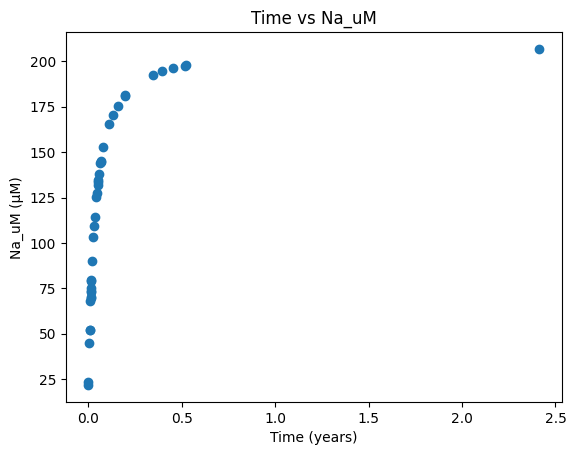

In [365]:
# plot time against concentration on the y
plt.scatter(df_copy['time'], df_copy[variable])
plt.xlabel('Time (years)')
plt.ylabel(f'{variable} (μM)')
plt.title(f'Time vs {variable}')
plt.show()

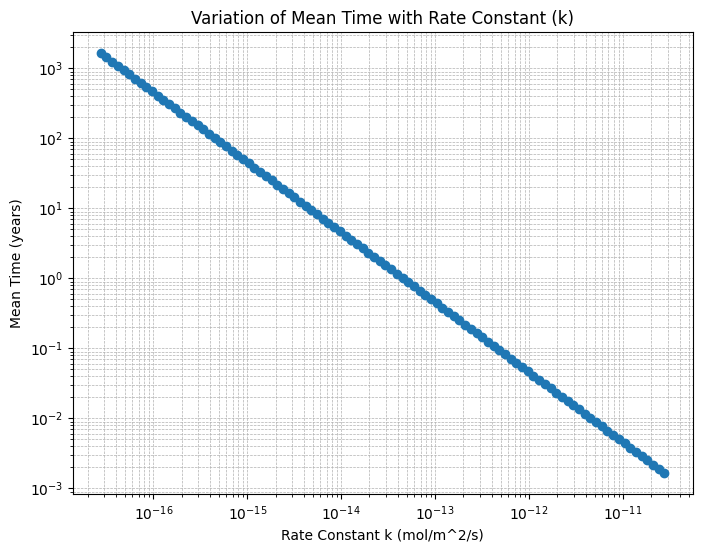

In [366]:
##### VARY FIXED K TO GET TIME VS K


# Fixed base k value
k_base = 8.7 * 10**-6 * 10**6  # Base k value in umol/m^2/year

# Generate a dictionary of k values from 0.01x to 100x the base value
k_range = np.logspace(-4, 2, 100) * k_base
k_dict = {f"k_{i}": k for i, k in enumerate(k_range)}

# Placeholder for k vs. average time results
k_vs_time = []

# Iterate over k values and compute mean times for each
for k_label, k_fixed in k_dict.items():
    # Recalculate R for the current k value
    R = rho_sf * k_fixed * A_surf * x_r

    # Calculate times for the current k value
    times = []
    for _, row in df_copy.iterrows():
        try:
            # Calculate D
            C = row[variable]
            if C == C_eq:  # Prevent division by zero
                times.append(np.nan)
                continue

            D = (C_zero - C) / (C - C_eq)

            # Solve for t
            if D <= 0:
                time = np.nan  # Invalid D value
            else:
                time = (D * C_eq) / (tau * phi * R * f_w)

            times.append(time)

        except Exception:
            times.append(np.nan)

    # Store the mean time for the current k value
    mean_time = np.nanmean(times)  # Ignore NaNs when calculating mean
    k_vs_time.append((k_fixed, mean_time))

# Convert results to a DataFrame for plotting
k_time_df = pd.DataFrame(k_vs_time, columns=["k", "mean_time"])

# convert k to mol/m^2/second
k_time_df['k_mol_m2_s'] = k_time_df['k'] * 3.1688*10**-14

# Plot k vs. mean time
plt.figure(figsize=(8, 6))
plt.plot(k_time_df["k_mol_m2_s"], k_time_df["mean_time"], marker='o', linestyle='-')
plt.xscale('log')  # Logarithmic scale for k
plt.yscale('log')  # Logarithmic scale for time
plt.xlabel("Rate Constant k (mol/m^2/s)")
plt.ylabel("Mean Time (years)")
plt.title("Variation of Mean Time with Rate Constant (k)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [367]:
# print what k values correspond to 50, 25, 10, 5 years
years = [50, 25, 10, 5]
for year in years:
    # Find the k value closest to the target year
    target_time = year
    closest_time = k_time_df.iloc[(k_time_df["mean_time"] - target_time).abs().argsort()[:1]]

    
    print(f"Closest k value to {target_time} years: {closest_time['k_mol_m2_s'].values[0]:.2e} mol/m ^2/s")

Closest k value to 50 years: 9.03e-16 mol/m ^2/s
Closest k value to 25 years: 1.81e-15 mol/m ^2/s
Closest k value to 10 years: 4.82e-15 mol/m ^2/s
Closest k value to 5 years: 9.68e-15 mol/m ^2/s


In [368]:
df_copy['Ca_uM'] = df_copy['Ca_mM'] * 1000
df_copy['Sr_uM'] = df_copy['Sr_mM'] * 1000
df_copy['Mg_uM'] = df_copy['Mg_mM'] * 1000
df_copy['Si_uM'] = df_copy['Si_mM'] * 1000
df_copy['Na_uM'] = df_copy['Na_mM'] * 1000
df_copy['Li_uM'] = df_copy['Li_mM'] * 1000
df_copy['K_uM'] = df_copy['K_mM'] * 1000
df_copy['Al_uM'] = df_copy['Al_mM'] * 1000
df_copy['Cl_uM'] = df_copy['Cl_mM'] * 1000

In [ ]:
# List of variables to process and plot
variables = ['Ca_uM', 'Sr_uM', 'Mg_uM', 'Si_uM', 'Na_uM', 'Li_uM', 'K_uM', 'Al_uM', 'Cl_uM']

# Placeholder to store results for validation or further analysis
time_results = {}

for variable in variables:
    # Ensure the variable exists and is numeric
    if variable in df_copy.columns and np.issubdtype(df_copy[variable].dtype, np.number):
        # Constants
        C_zero = df_copy[variable].min()
        C_max = df_copy[variable].max()
        C_eq = C_max
        tau = np.exp(2)
        phi = 0.15
        rho_min = 2.67  # g/cm^3
        rho_sf = 1000 * rho_min / phi  # g/L
        A_surf = 0.1
        x_r = 0.36
        f_w = 1  # approximately

        # Fixed k value
        k_fixed = 8.7 * 10**-6 * 10**6  # to get from mol/m^2/year to umol/m^2/year

        # Calculate R
        R = rho_sf * k_fixed * A_surf * x_r

        # Empty list for time results
        times = []

        for index, row in df_copy.iterrows():
            try:
                # Calculate D
                C = row[variable]
                if C == C_eq:  # Prevent division by zero
                    times.append(np.nan)
                    continue

                D = (C_zero - C) / (C - C_eq)

                # Solve for t
                if D <= 0:
                    time = np.nan  # Invalid D value
                else:
                    time = (D * C_eq) / (tau * phi * R * f_w)

                times.append(time)
            except Exception as e:
                times.append(np.nan)

        # Add the `time` column to the dataframe
        df_copy[f'{variable}_time'] = times
        time_results[variable] = times

        # # Plot the variable against time
        # plt.figure(figsize=(8, 5))
        # plt.scatter(df_copy[f'{variable}_time'], df_copy[variable], alpha=0.7)
        # plt.title(f'{variable} vs Time')
        # plt.xlabel('Time (years)')
        # plt.ylabel(f'{variable} (uM)')
        # plt.grid(True)
        # #plt.show()


In [370]:
# calculate the relative time spent in the water column for each element for each sample

# List of element variables
elements = ['Ca_uM', 'Sr_uM', 'Mg_uM', 'Si_uM', 'Na_uM', 'Li_uM', 'K_uM', 'Al_uM', 'Cl_uM']

# Normalize each element's time proportion by dividing by Na's time
reference_element = 'Na_uM_time_proportion'  # Reference element for normalization (Na)

for index, row in df_copy.iterrows():
    # Get Na's time proportion for this sample
    na_time_proportion = row.get(reference_element, np.nan)
    
    # Check if Na's time proportion is valid
    if not np.isnan(na_time_proportion) and na_time_proportion > 0:
        # Normalize all time proportions by Na's time proportion
        for element in elements:
            proportion_col = f'{element}_time_proportion'
            if proportion_col in df_copy.columns:
                current_value = row[proportion_col]
                if not np.isnan(current_value):
                    df_copy.loc[index, f'{element}_time_normalized'] = current_value / na_time_proportion

# Extract normalized time columns
time_normalized_columns = [f'{element}_time_normalized' for element in elements]

# Plot normalized time proportions for each sample
for index, row in df_copy.iterrows():
    # Extract normalized proportions for the current sample
    sample_normalized = [row[col] for col in time_normalized_columns if col in df_copy.columns and not np.isnan(row[col])]
    corresponding_elements = [element for element in elements if f'{element}_time_normalized' in df_copy.columns]

    # Plot if valid data exists
    if sample_normalized:
        plt.figure(figsize=(8, 5))
        plt.bar(corresponding_elements[:len(sample_normalized)], sample_normalized, alpha=0.7, color='skyblue')
        plt.title(f'Time Proportions Normalized to Na for Sample {index}')
        plt.ylabel('Normalized Time (Relative to Na)')
        plt.xlabel('Elements')
        plt.xticks(rotation=45)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()



In [371]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import numpy as np
import matplotlib.pyplot as plt

# Prepare data
normalized_data = df_copy[time_normalized_columns].dropna()

# Sample indices (x-axis for GP)
sample_indices = np.arange(len(normalized_data)).reshape(-1, 1)

# Fit a GP for each element
for element, col in zip(elements, time_normalized_columns):
    if col in normalized_data:
        # Extract normalized times for the element
        y = normalized_data[col].values.reshape(-1, 1)
        
        # Kernel: Constant * RBF
        kernel = C(1.0, (1e-3, 1e3)) * RBF(1, (1e-2, 1e2))
        gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
        
        # Fit GP to the data
        gp.fit(sample_indices, y)
        
        # Predict mean and standard deviation
        x_pred = np.linspace(0, len(normalized_data) - 1, 100).reshape(-1, 1)
        y_mean, y_std = gp.predict(x_pred, return_std=True)
        
        # Plot results
        plt.figure(figsize=(8, 5))
        plt.plot(sample_indices, y, 'kx', label='Observed', markersize=8)
        plt.plot(x_pred, y_mean, 'b-', label='GP Mean')
        plt.fill_between(
            x_pred.flatten(),
            y_mean.flatten() - 1.96 * y_std,
            y_mean.flatten() + 1.96 * y_std,
            alpha=0.2,
            color='blue',
            label='95% Confidence Interval'
        )
        plt.title(f'Gaussian Process for {element}')
        plt.xlabel('Sample Index')
        plt.ylabel(f'Normalized Time (Relative to Na)')
        plt.legend()
        plt.grid(True)
        plt.show()


KeyError: "None of [Index(['Ca_uM_time_normalized', 'Sr_uM_time_normalized',\n       'Mg_uM_time_normalized', 'Si_uM_time_normalized',\n       'Na_uM_time_normalized', 'Li_uM_time_normalized',\n       'K_uM_time_normalized', 'Al_uM_time_normalized',\n       'Cl_uM_time_normalized'],\n      dtype='object')] are in the [columns]"

In [ ]:
print(df_copy.columns)


Index(['Sample ID', 'GNS', 'Season', 'Date', 'Time', 'Sample type',
       'Repeat_collection', 'Site_details', 'Traverse', 'Traverse_new',
       ...
       'Al_uM', 'Ca_uM_time', 'Sr_uM_time', 'Mg_uM_time', 'Si_uM_time',
       'Na_uM_time', 'Li_uM_time', 'K_uM_time', 'Al_uM_time', 'Cl_uM_time'],
      dtype='object', length=110)
